In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../..")

In [3]:
import deepmatcher as dm
from utils.intermediate_layer_extraction import return_layer_input
from utils.ri_calculator import computeRi
from utils.explainer import Explainer
import pandas as pd

In [4]:
attributes =['title','manufacturer','price']

### Dataset creation

In [5]:
rnn_model = dm.MatchingModel(attr_summarizer='rnn')
rnn_model.load_state('../../models/amazongoogle_rnn.pth')
rnn_model = rnn_model.cuda()

In [6]:
testneg_classifier,testneg_ids = return_layer_input('../../Structured/Amazon-Google/'
                                                                         ,'test_negatives',128,rnn_model,
                                                                        rnn_model.classifier)

In [7]:
testpos_classifier,testpos_ids = return_layer_input('../../Structured/Amazon-Google/',
                                                                  'test_positives',128,rnn_model,
                                                                  rnn_model.classifier)

In [8]:
neg_classifier,neg_ids = return_layer_input('../../Structured/Amazon-Google/'
                                                                         ,'negatives',512,rnn_model,
                                                                        rnn_model.classifier)

In [9]:
pos_classifier,pos_ids = return_layer_input('../../Structured/Amazon-Google/','positives',
                                                          512,rnn_model,rnn_model.classifier)

In [10]:
classifier_len = len(pos_classifier[0][0])
attribute_len = int(classifier_len/len(attributes))

### Negatives analysis

In [11]:
negatives_ri,neg_ri_norms = computeRi(rnn_model.classifier,
                                                    attributes,testneg_classifier,attribute_len,1)

100%|██████████| 128/128 [00:04<00:00, 30.38it/s]


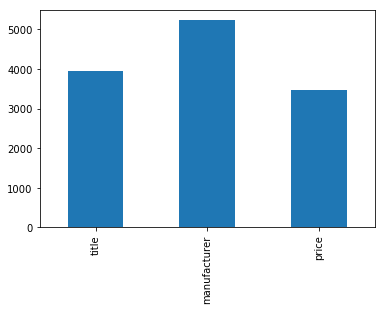

In [13]:
negatives_variation_df = pd.DataFrame(data= neg_ri_norms,columns=attributes)
negatives_variation_df.sum().plot.bar()

In [14]:
##save to file
negatives_variation_df.to_csv('experiment_results/testnegRiRNN.csv',index=False)

## Test positives analysis

In [15]:
positives_ri,pos_ri_norms = computeRi(rnn_model.classifier,
                                                    attributes,testpos_classifier,attribute_len,0)

100%|██████████| 106/106 [00:00<00:00, 165.23it/s]


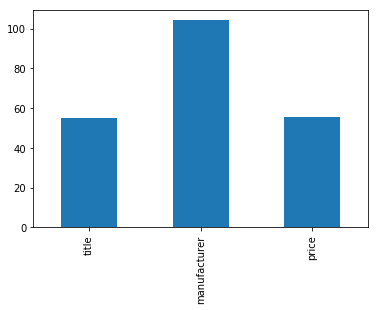

In [16]:
positives_variation_df = pd.DataFrame(data= pos_ri_norms,columns=attributes)
positives_variation_df.sum().plot.bar()

In [18]:
##Save results to file
positives_variation_df.to_csv('experiment_results/testposRiRNN.csv',index=False)

## Compute nearest neighbours

In [19]:
from utils.distance_measures import calculate_nearest_neighbors_onAttributes

In [20]:
positives_nn = calculate_nearest_neighbors_onAttributes(testpos_classifier,testpos_ids,positives_ri,
                                                       neg_classifier,neg_ids,attributes,attribute_len)

100%|██████████| 106/106 [00:00<00:00, 249.27it/s]


In [21]:
negatives_nn = calculate_nearest_neighbors_onAttributes(testneg_classifier,testneg_ids,
                                                              negatives_ri,pos_classifier,
                                                              pos_ids,attributes,attribute_len)

100%|██████████| 128/128 [00:00<00:00, 755.90it/s]


In [22]:
positives_nn.to_csv('experiment_results/testposNN_RNN.csv',index=False)
negatives_nn.to_csv('experiment_results/testnegNN_RNN.csv',index=False)